# First order Nomoto model for ship maneuvering dynamics
> Implementation of the so called first order Nomoto model for ship maneuvering dynamics

- toc: true
- branch: master
- badges: true
- comments: true
- categories: [simulation, dynamics, spring mass damper]
- image: images/nomoto.png
- hide: false
- search_exclude: true
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2

The first order Nomoto model can be written as:
$$ K \cdot \delta=r+T_{1} \cdot \dot{r}+T_{2} \cdot \ddot{r} $$
where $r$ is yaw rate with its time derivatives and $\delta$ is the rudder angle. $K$, $T_{1}$
 and $T_{1}$ are the coefficients describing the hydrodynamics of the ship.

In [1]:
#hide
import warnings
warnings.filterwarnings("ignore")

In [2]:
#collapse
from scipy.integrate import odeint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Simulate a pull out manoeuvre

In [3]:
#collapse
K = 0.1
delta = 0.15
T_1 = 10

def nomoto(states,t):
    
    # states:
    # [psi, r, r1d]
    # K*delta = r + T_1*r1d
    # --> r = K*delta - T_1*r1d + T_2*r2d
    # --> r1d = (K*delta - r - T_2*r2d)/T_1 
    
    psi = states[0]
    r = states[1]
    
    r1d_ = (K*delta - r)/T_1 
    
    d_states_dt = np.array([r,r1d_])
    
    return d_states_dt

In [4]:
states_0 = np.array([0,0])
t = np.linspace(0,30,100)
states = odeint(func = nomoto,y0 = states_0,t = t)
psi = states[:,0]
r = states[:,1]


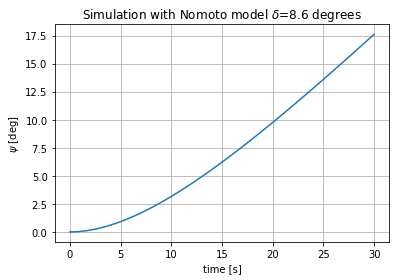

In [5]:
fig,ax=plt.subplots()
ax.plot(t,np.rad2deg(psi));
ax.grid(True)
ax.set_title('Simulation with Nomoto model $\delta$=%0.1f degrees' %np.rad2deg(delta))
ax.set_ylabel('$\psi$ [deg]')
ax.set_xlabel('time [s]');

## Simulate a ZigZag test

In [6]:
#collapse

K = 0.2
delta = 0.15
T_1 = 10

def nomoto_zigzag(states,t, angle=np.deg2rad(10)):
    
    # states:
    # [psi, r, r1d]
    # K*delta = r + T_1*r1d
    # --> r = K*delta - T_1*r1d + T_2*r2d
    # --> r1d = (K*delta - r - T_2*r2d)/T_1 
    
    psi = states[0]
    r = states[1]
    
    #ZigZag autopilot:
    sign=-1
    psi_pluss = ((psi>=0) and (psi<angle))
    psi_minus = ((psi>=-angle) and (psi<=0))
    
    if (
        (psi_pluss and (r>=0)) |
        (psi<-angle) |
        (psi_minus and (r>=0))
        
        
    ):
        sign=1   
    delta_=sign*delta
    
    #Nomoto equation:
    r1d_ = (K*delta_ - r)/T_1 
    d_states_dt = np.array([r,r1d_])
    
    return d_states_dt

In [7]:
angle=np.deg2rad(10)
states_0 = np.array([0,0])
t = np.linspace(0,100,100)
states = odeint(func = nomoto_zigzag,y0 = states_0,t = t, args=(angle,))
psi = states[:,0]
r = states[:,1]

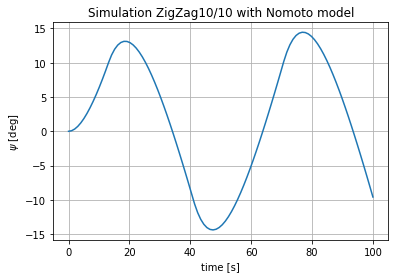

In [8]:
fig,ax=plt.subplots()
ax.plot(t,np.rad2deg(psi));
ax.grid(True)
ax.set_title('Simulation ZigZag%0.0f/%0.0f with Nomoto model' % (np.rad2deg(angle),np.rad2deg(angle)))
ax.set_ylabel('$\psi$ [deg]')
ax.set_xlabel('time [s]');